In [1]:
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import qr, solve_triangular
import numpy as np
import cartopy.crs as ccrs
from scipy.optimize import newton

# Assignment 3

In [2]:
sst = xr.open_dataset('test.nc', engine='scipy').sst
sst
sst['time.month']


<xarray.DataArray 'month' (time: 1572)>
array([ 1,  2,  3, ..., 10, 11, 12], dtype=int64)
Coordinates:
  * time     (time) object 1870-01-01 00:00:00 ... 2000-12-01 00:00:00

In [3]:
def compute_grouped_mon_anom(data_array):
    grouped_by_months= data_array.groupby("time.month")
    monthly_means= grouped_by_months.mean(dim="time")

    monthly_anomalies= grouped_by_months #- monthly_means
    anom_mons=monthly_anomalies#.groupby("time.month")
    
    return anom_mons

In [4]:
sst_100 = sst[360:1572,:,:]
sst_100_dec = compute_grouped_mon_anom(sst_100)[12]

In [23]:
def create_datasubset(data, timescale):
    x = 1572-(timescale+1)*12 #total number of timesteps - require number of year * number of months Per year
    sst_month= sst[x:1572,:,:]
    return sst_month

# Question 1 : SST trends
Goal is to compute OLS coefficients for every lat lon data point in the n-d data set. The sign and the magitude of the slopes would be indicative of the trends. 
#
We'll use the OLS code from before to achieve this.

In [48]:
def back_sub(R, y):
    number_of_rows, number_of_cols = R.shape
    
    x_hat = np.zeros(number_of_cols)
    
    i = number_of_cols-1
    
    x_hat[i] = y[i]/R[i,i]
    
    for i in range(number_of_cols-2, -1, -1):

        for j in range(number_of_cols-1, i, -1):
            
            x_hat[i] = x_hat[j]*R[i,j]
            
        x_hat[i] = (y[i] - x_hat[i])/R[i,i]
    
    return x_hat


In [49]:
def compute_slope_OLS(x,y):
    B = np.column_stack([x,np.ones(len(x))])
    Q, R = qr(B)
    z = Q.T@y
    
    x_hat=back_sub(R,z)

    return x_hat[0] #returns only the slope


In [28]:
def plotter(data_array):
    %matplotlib inline
    ax= plt.subplot(projection=ccrs.PlateCarree())

    data_array.plot.contourf(ax=ax, cbar_kwargs = dict(orientation='horizontal',label='W/m^2'), levels=25)


    ax.coastlines()
    ax.gridlines(draw_labels=True,crs=ccrs.PlateCarree())

In [9]:
# now we need to create a function to compute trends for every lat lon coord box
# approach is to fit a line to sst data over time for a box and compute the slope of the line

def compute_slope_of_latlonbox(data_array, lat, lon):
    y=[] #response variable
    y=data_array[:,lat,lon].values
    x= np.arange(0, len(data_array['time'].values))
    return compute_slope_OLS(x,y)


    

In [16]:
dict_trends={}

for i in range (1,13):
    dict_trends[i]=[]
    
#initializing a dictionary with keys as different month indexes

In [17]:
for month in range(1,13):
    sst_for_month = compute_grouped_mon_anom(sst_100)[month]
    for i in range(0, len(sst_for_month.coords['lat'])):
        for j in range(0, len(sst_for_month.coords['lon'])):
            slope=compute_slope_of_latlonbox(sst_for_month, i, j)
            dict_trends[month].append(slope)

In [18]:
arrayfied_data = np.array(dict_trends[12]).reshape(89, 180)
data_array = xr.DataArray(arrayfied_data, dims = ['lat', 'lon'], coords = {'lat': sst.coords['lat'], 'lon': sst.coords["lon"]})

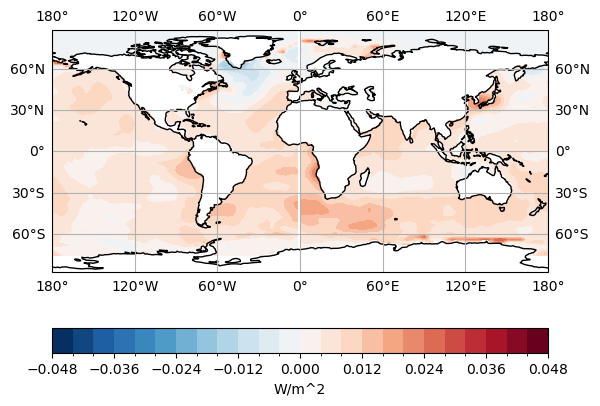

In [29]:
plotter(data_array)

In [30]:
#putting all of the above testing into a function for ease of access
def compute_trends (data, timescale, month_index):
    data_truncated= create_datasubset(data,timescale)
    dict_trends={}

    for i in range (1,13):
        dict_trends[i]=[]
    for month in range(1,13):
        data_for_month = compute_grouped_mon_anom(data_truncated)[month]
        for i in range(0, len(data_for_month.coords['lat'])):
            for j in range(0, len(data_for_month.coords['lon'])):
                slope=compute_slope_of_latlonbox(data_for_month, i, j)
                dict_trends[month].append(slope)
    #convert the data to an array for plotting
    arrayfied_data = np.array(dict_trends[month_index]).reshape(89, 180)
    data_array = xr.DataArray(arrayfied_data, dims = ['lat', 'lon'], coords = {'lat': sst.coords['lat'], 'lon': sst.coords["lon"]})
    return data_array, dict_trends

In [31]:
dec_trends_at_100 = compute_trends(sst,100,12)
dec_trends_at_50 = compute_trends(sst,50,12)
dec_trends_at_20 = compute_trends(sst,20,12)

The above code takes a while to run but the outputs can be used indefinitely. Information is stored in the dictionary and can be converted to dataarray of the desired month when needed. Here, I am looking at trends at december.

In [39]:
dec_trends_at_100_dataarray, trends_at_100_dict = dec_trends_at_100
dec_trends_at_50_dataarray, trends_at_50_dict = dec_trends_at_50
dec_trends_at_20_dataarray, trends_at_20_dict = dec_trends_at_20


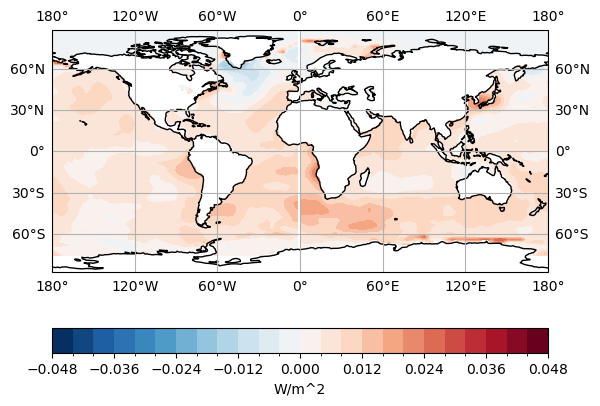

In [34]:
plotter(dec_trends_at_100_dataarray)

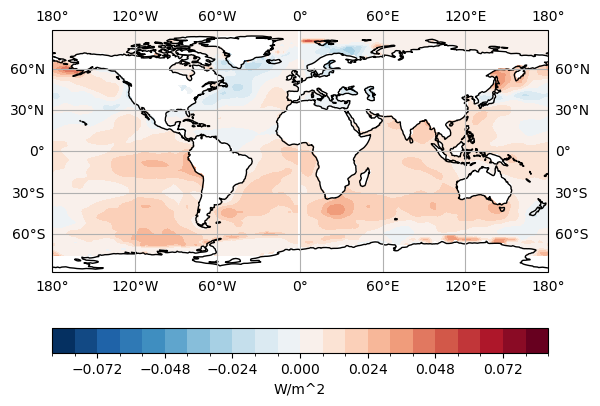

In [36]:
plotter(dec_trends_at_50_dataarray)

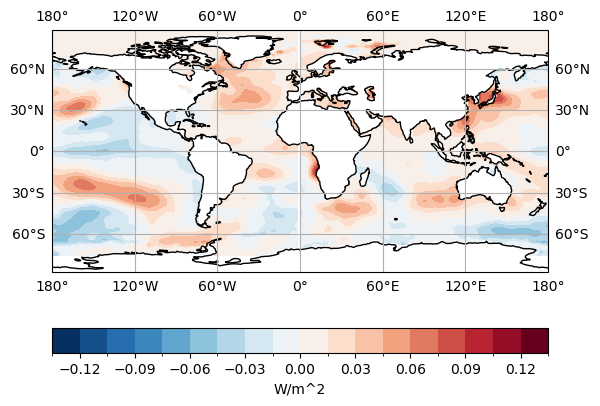

In [35]:
plotter(dec_trends_at_20_dataarray)

In [38]:
def convert_to_array (dictionary, month_index):
    arrayfied_data = np.array(dictionary[month_index]).reshape(89, 180)
    
    data_array = xr.DataArray(arrayfied_data, dims = ['lat', 'lon'], coords = {'lat': sst.coords['lat'], 'lon': sst.coords["lon"]})
    
    return data_array

In [44]:
#please change the month index to view the desired month

oct_trends_at_100 = convert_to_array(trends_at_100_dict,10)
oct_trends_at_50 = convert_to_array(trends_at_50_dict,10)
oct_trends_at_20 = convert_to_array(trends_at_20_dict,10)

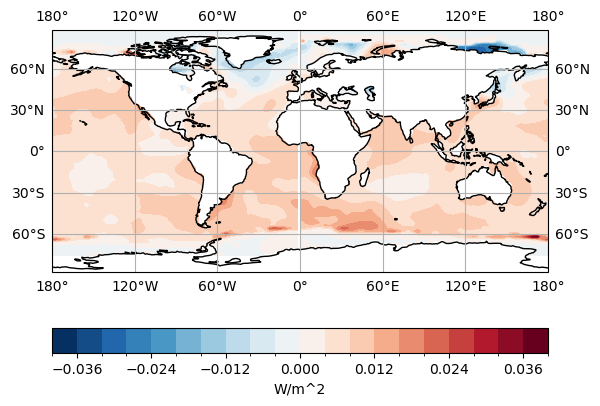

In [45]:
plotter(oct_trends_at_100)

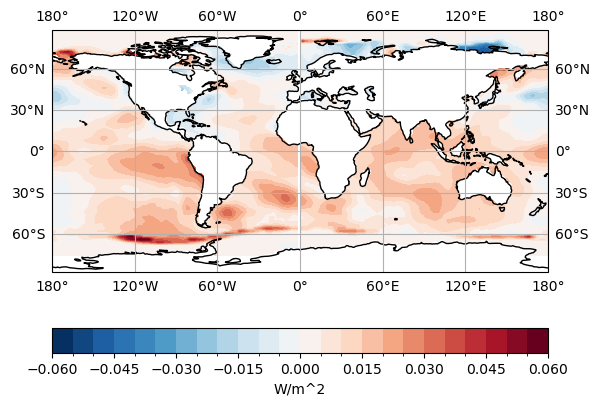

In [46]:
plotter(oct_trends_at_50)

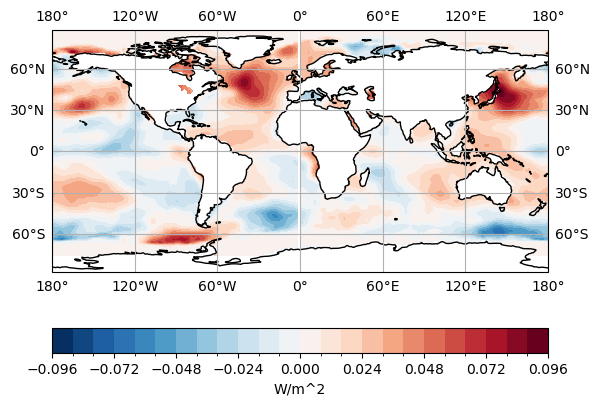

In [47]:
plotter(oct_trends_at_20)

### Trends in the trends
As we can see there is a general "trend" of heating of the southern hemisphere and cooling of the northern hemisphere in 100 and 50 year timescales, but this is more pronounced in the 50 year timescale.<br> The cooling in the northern hemispheres, escpecially the one near greenland is due to ice melting and cold melt water influx into the oceans. We can see that in the 20 year timescale plot, the are near greenland is infact heating. <br>
Small scale variations are caught in the 20 year timesclae trends, which are due to short scale events like ENSO or PDO. Larger scale variations are caught in the 50 year and 100 year timescale plots, which capture information about big timescale events like ice cap melting due to global warming. <br> 
Note : Positive slope means increase in temperature over time and negative slope means decrease in temperature over time.<br>

### Hotspots of cooling and heating
1. 100 year timescale : Southern hemisphere heating, Northern hemisphere cooling
2. 50 year timescale : Southern hemisphere heating relatively more than at 100 year time scale and northern hemisphere cooling. We can also see localized heating and cooling "events" like the one West of south america and south of greenland.
3. 20 year timescale : The above pattern flips, northern hemisphere heating more than southern hemisphere. Patches of cooling areas in the ocean like the one east of south america. Also large patches of heating can be seen like the ones near greenland and japan.

# Question 2 : EOF and PCS


# Part 1 : Orthogonality of Singular matrices and ENSO events

In [1]:
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sst = xr.open_dataset('test.nc', engine='scipy').sst


In [3]:
#this block computes monthly anomalies data from the sst data

selected_sst = sst#[360:1572,:,:]

sst_monthly_mean = selected_sst.groupby('time.month').mean()

anomalies = selected_sst.groupby('time.month') - sst_monthly_mean

coslat = np.cos(np.deg2rad(selected_sst.coords['lat'].values))
latitude_wgts = np.tile(coslat, (len(sst.lon), 1)).transpose()
wgts = np.tile(latitude_wgts, (len(selected_sst.time), 1, 1))

zero_mean_anomalies = anomalies - (anomalies*wgts).mean(dim=['lat', 'lon'])

In [4]:
solver = Eof(zero_mean_anomalies, weights=latitude_wgts)

In [5]:
#solving for the two singular matrices
eofs = solver.eofs(neofs=3, )
pcs = solver.pcs(npcs=3, pcscaling=1)

In [20]:
pcs_matrix = pcs.values #matrix with all three pcs stored in rows
np.matmul(pcs_matrix.T,pcs_matrix)

array([[1.57100000e+03, 3.42614825e-13, 2.33701947e-13],
       [3.42614825e-13, 1.57100000e+03, 1.60943481e-12],
       [2.33701947e-13, 1.60943481e-12, 1.57100000e+03]])

We can see here that when PCS are the same, their product is the same as the number of timesteps and when its two different PCS their product is a small number close to 0. <br> Note : In the matrix generated as result, values in the diagonal show product of a pcs vector with itself and values not in the diagonal show product with other pcs. 

In [21]:
EOF1_dropnan= eofs[0].values[~np.isnan(eofs[0].values)]
EOF2_dropnan= eofs[1].values[~np.isnan(eofs[1].values)]
EOF3_dropnan= eofs[2].values[~np.isnan(eofs[2].values)]

EOF_matrix = np.matrix([EOF1_dropnan,
                       EOF2_dropnan,
                       EOF3_dropnan])
#matrix with all three eofs stored in rows

np.matmul(EOF_matrix,EOF_matrix.T)

matrix([[ 1.00000000e+00, -9.69003574e-16,  1.46035993e-15],
        [-9.69003574e-16,  1.00000000e+00, -3.17705060e-15],
        [ 1.46035993e-15, -3.17705060e-15,  1.00000000e+00]])

We can see here that when EOFS are the same, their product is 1 and when its two different EOFS their product is a small number close to 0. <br>
Note : In the matrix generated as result, values in the diagonal show product of a EOF vector with itself and values not in the diagonal show product with other EOFs. 

The next plot is just to see what they look like!

In [47]:
len(np.arange (10,1572,12))

131

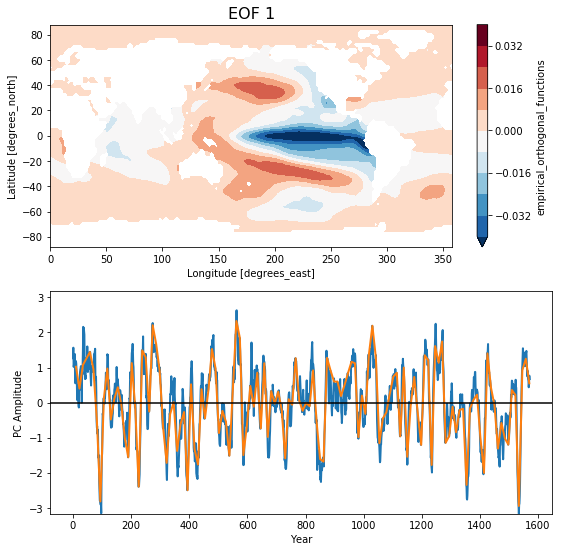

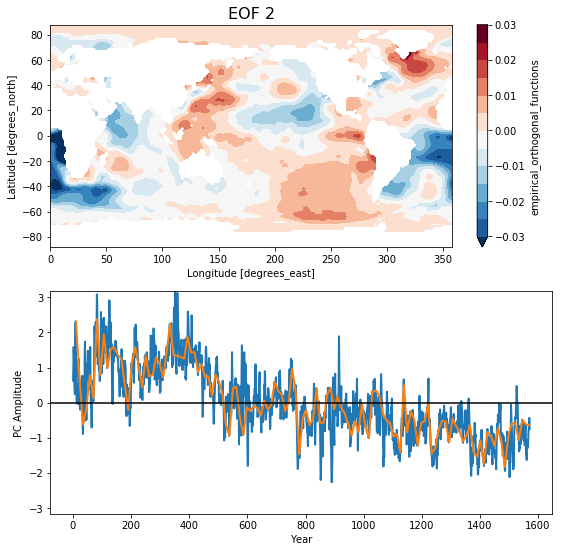

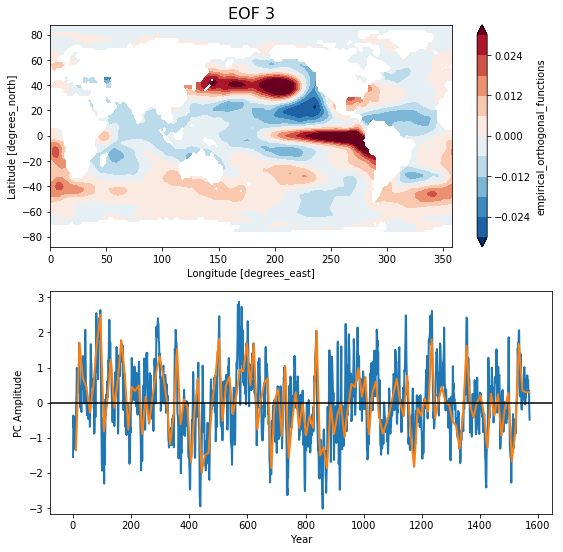

In [49]:
%matplotlib inline
for i in range(0,3):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)
    (eofs[i,:,:]).plot.contourf(levels=12, robust=True)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    # orinigal segregation of data. Please comment this section of the code to not see pcs for unaltered data
    tot_days_yearly = np.arange (0,1572)
    plt.plot(tot_days_yearly, pcs[:,i], linewidth=2) 

    # monthly segregation of data
    # please change the month as required by changing the month variablefrom 1 to 12.
    month=10
    tot_days_monthly = np.arange(month,1572, 12)
    plt.plot(tot_days_monthly, pcs[:,i].groupby("time.month")[month], linewidth=2)

    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    plt.ylim(np.min(pcs.squeeze()), np.max(pcs.squeeze()))

In [6]:
def largest_indices(data, number_of_max):
    
    flat = data.values
    indices = np.argpartition(flat, -number_of_max)[-number_of_max:]
    indices = indices[np.argsort(-flat[indices])]

    return np.unravel_index(indices, data.shape) #returns the indices of the number_of_max many highest values



In [64]:
#indices of greatest pcs in the +ve direction
largest_indices(pcs[:,0].groupby("time.month")[10],5)

(array([ 46,  22,  85,  47, 105], dtype=int64),)

In [75]:
#indices of greatest pcs in the -ve direction
largest_indices(-pcs[:,0].groupby("time.month")[10],5)

(array([127,   7,  32,  18, 112], dtype=int64),)

In [92]:
#indices of greatest pcs in magnitude 
largest_indices(np.abs(pcs[:,0].groupby("time.month")[10]),5)

(array([127,   7,  32,  18, 112], dtype=int64),)

In [89]:
pcs[:,0].groupby("time.month")[10][127]
pcs[:,0].groupby("time.month")[10][7]
pcs[:,0].groupby("time.month")[10][32]
pcs[:,0].groupby("time.month")[10][18]
pcs[:,0].groupby("time.month")[10][112]


<xarray.DataArray 'pcs' ()>
array(-2.3434271)
Coordinates:
    time     object 1982-10-01 00:00:00
    mode     int32 0
    month    int64 10

### Strongest ENSO events:
Since it is hard to tell which sign corresponds to La nina/ El nino without prior knowledge (as the pcs vector could be in either direction for either of them), top 5 absolute events are listed below : <br>
1. 1997
2. 1877
3. 1902
4. 1888
5. 1982 <br>
<p>
Month 10 (october) was used as the proxy for measuring greatest ENSO events as ENSO events occur on timescales larger than a year. October is fairly decent as a proxy for when an ENSO event is occuring due to it being the onset of winter and occuring just after autumnal equinox.


# Part 2 : Creating and playing with new eofs



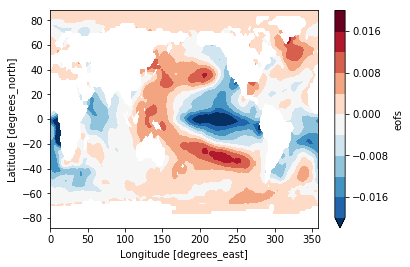

In [7]:
EOF1=eofs[0,:]
EOF2=eofs[1,:]
V1= (EOF1+EOF2)/2  #new eofs called v1
V1.plot.contourf(levels=12, robust=True)

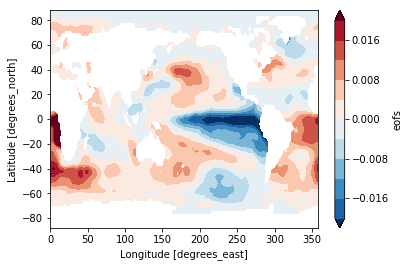

In [8]:
EOF1=eofs[0,:]
EOF2=eofs[1,:]
V2= (EOF1-EOF2)/2 #new eofs called v2
V2.plot.contourf(levels=12, robust=True)

In [9]:
#function to drop nan as they create a problem when used for computation
def nan_dropper (data):
    data_wo_nan=data.values[~np.isnan(data.values)]
    return data_wo_nan

V1_dropped=nan_dropper(V1)

zero_mean_anomalies_dropped= nan_dropper(zero_mean_anomalies[0])

zero_mean_anomalies_dropped

array([-0.30526667, -0.42584925, -0.45220845, ..., -0.10241466,
       -0.10241466, -0.10241466])

In [10]:
np.dot(zero_mean_anomalies_dropped,V1_dropped)
pcs_of_V1=[]
for i in range (0,len(zero_mean_anomalies.coords["time"])):
    zero_mean_anomalies_dropped= nan_dropper(zero_mean_anomalies[i])
    #zero_mean_anomalies_dropped_magnitude = np.dot
    zero_mean_anomalies_dropped_normalized= np.linalg.norm(zero_mean_anomalies_dropped)

    pcs_for_ith_time=np.dot(zero_mean_anomalies_dropped_normalized,V1_dropped)
    pcs_of_V1.append(pcs_for_ith_time)


In [11]:
def generate_pcs_from_eofs (data_array, eofs):
    pcs_of_array=[]

    for i in range (0,len(data_array.coords["time"])):

        eofs_nandropped=nan_dropper(eofs)
        data_array_nandropped= nan_dropper(data_array[i])

        data_array_nandropped_mag= np.sqrt(np.dot(data_array_nandropped, data_array_nandropped))
        data_array_nandropped_normalized = data_array_nandropped/(data_array_nandropped_mag)

        pcs_for_ith_time=np.dot(data_array_nandropped_normalized,eofs_nandropped)

        pcs_of_array.append(pcs_for_ith_time)
     
    return pcs_of_array


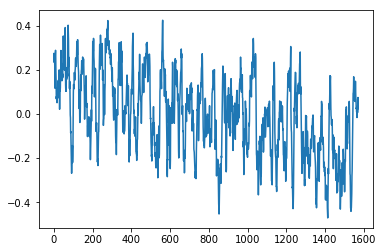

In [12]:
plt.plot(np.arange(0,1572), generate_pcs_from_eofs(zero_mean_anomalies, V1))

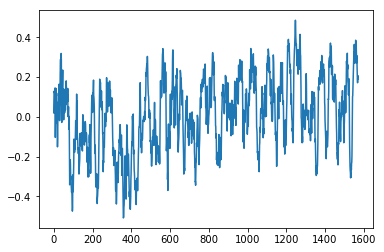

In [13]:
plt.plot(np.arange(0,1572), generate_pcs_from_eofs(zero_mean_anomalies, V2))

In [32]:
V1_dropnan= V1.values[~np.isnan(eofs[0].values)]
V2_dropnan= V2.values[~np.isnan(eofs[1].values)]

V_matrix = np.matrix([V1_dropnan,
                       V2_dropnan])
#matrix with the two new eofs stored in rows

np.matmul(V_matrix,V_matrix.T)

matrix([[ 5.00000000e-01, -1.45395783e-15],
        [-1.45395783e-15,  5.00000000e-01]])

We can see here that the new eofs are indeed perpendicular to each other, i.e., the V-matrix is orthogonal. <br>This is because EOF1 vector and EOF2 vector are of the same length. Hence, their sum/2 and difference/2 are perpendicular to each other and are also of the same length.

But, lets look at what happens we we try out the same of the pcs we generated for these new V1 and V2.

In [33]:

y=np.matrix([generate_pcs_from_eofs(zero_mean_anomalies, V1),
           generate_pcs_from_eofs(zero_mean_anomalies, V2)])
norm_y= np.matrix([pcs[:,0],
                   pcs[:,1]])
np.matmul(y,y.T)

matrix([[52.23139737, 20.33983382],
        [20.33983382, 53.50225299]])

They aren't perpendicular!!!<br>
But why?
<p>
The pcs of the initial two eofs (eof1 and eof2) were independent as they are the variances represented by the individual eofs, but this doesn't have to hold for the rotated eofs V1 and V2. This is one key difference between the new rotated pcs and original pcs.</p>
Note: I call V1 and V2 "rotated" as the operation is essentially the same (for vectors of same magnitude) as rotating them by 45 degrees.

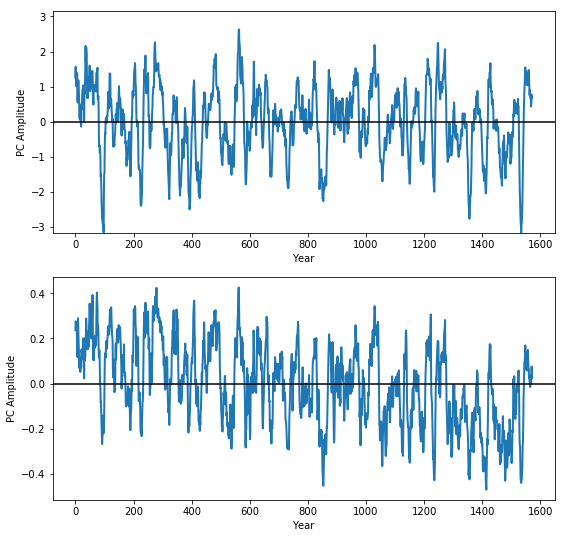

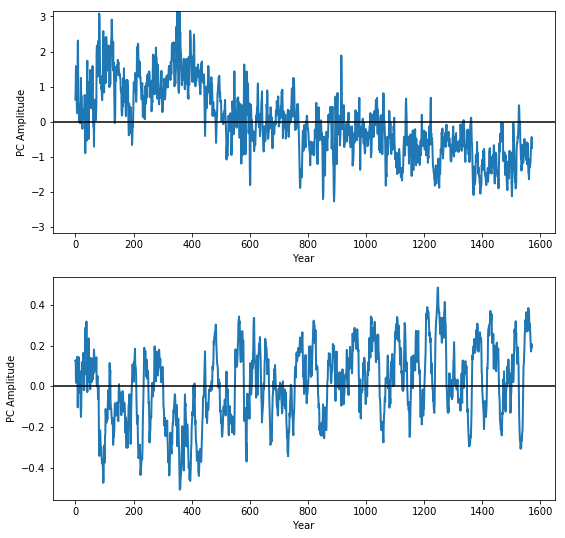

In [25]:
%matplotlib inline
for i in range(0,2):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)

    tot_days_yearly = np.arange (0,1572)
    plt.plot(tot_days_yearly, pcs[:,i], linewidth=2) 

    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    plt.ylim(np.min(pcs.squeeze()), np.max(pcs.squeeze()))

    plt.subplot(212)

    if i==0:
        plt.plot(tot_days_yearly, generate_pcs_from_eofs(zero_mean_anomalies, V1), linewidth=2) 
    else:
        plt.plot(tot_days_yearly, generate_pcs_from_eofs(zero_mean_anomalies, V2), linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')   
    

Another difference from PCS and new PCs generated by V1 and V2 is the difference in magnitude, which is probably due to us not dividing it by 1/rt(sigma) [division by root of variance]. <br>
While in the original pcs, one is generally "straight" about x axis and the other is tilted; For the new pcs both are titled, suggesting that they are formed by some combination of these two different effects. This takes into account and helps us look at the possibility that emergent phenomenon can occur due to combined effects of two different events.

# Part 3 : Looking at differences between V and EOF

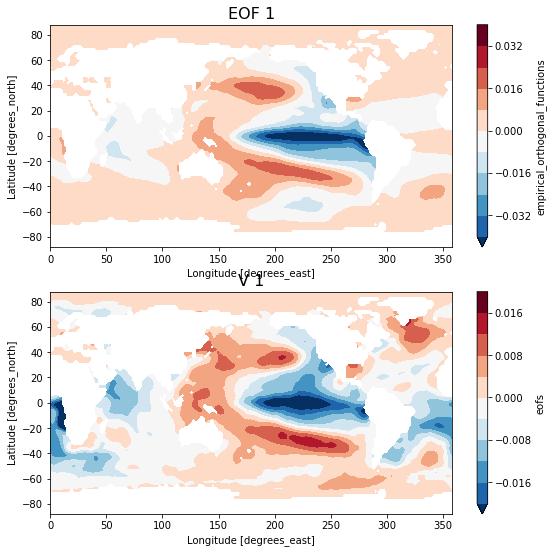

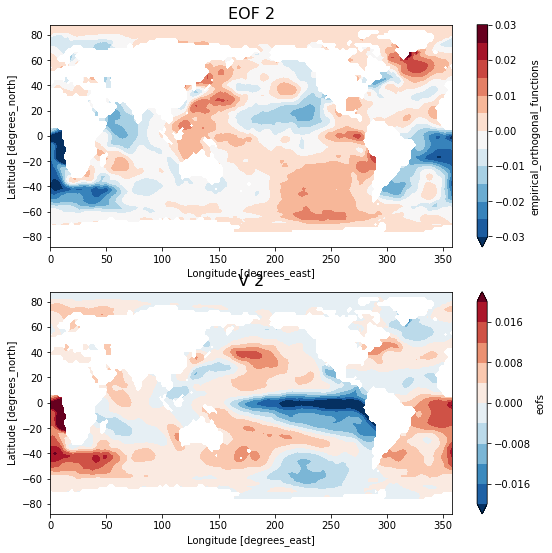

In [14]:
%matplotlib inline
for i in range(0,2):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)
    (eofs[i,:,:]).plot.contourf(levels=12, robust=True)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    
    if i==0:
        (V1).plot.contourf(levels=12, robust=True)
    else :
        (V2).plot.contourf(levels=12, robust=True)
    plt.title('V ' + str(i+1), fontsize=16)
    plt.tight_layout
    

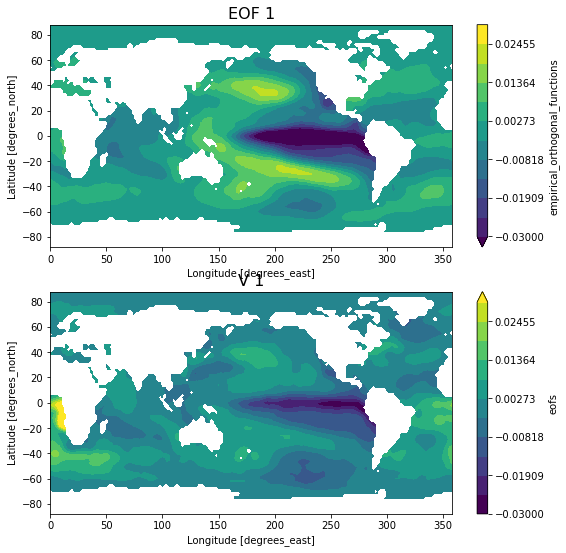

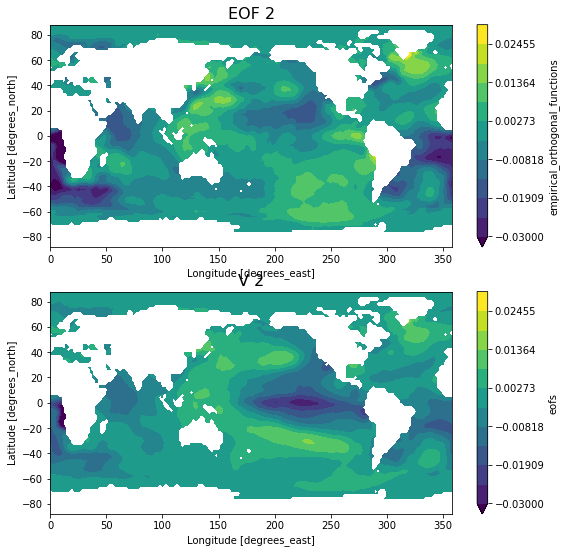

In [37]:
%matplotlib inline
for i in range(0,2):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)
    (eofs[i,:,:]).plot.contourf(levels=12, robust=True,vmin=-0.03 , vmax=0.03)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    
    if i==1:
        (V1).plot.contourf(levels=12, robust=True,vmin=-0.03 , vmax=0.03)
    else :
        (V2).plot.contourf(levels=12, robust=True,vmin=-0.03 , vmax=0.03)
    plt.title('V ' + str(i+1), fontsize=16)
    plt.tight_layout
    

It is difficult to directly draw inferences from the following graphs, but two main things stand out : <br>
<.> The new eofs (V1 and V2) help in looking at combined effects of EOF1 and EOF2; help in noticing variantions/phenomenons that occur due to a culmination of the intial eofs. <br>
<.> This allows for us to see finer details in the spatial variations of sst, and some details that would be harder to spot in the original eofs (for example; pacific decadal oscillations) show up more pronounced with the help of the new eofs. <br><br>
But a potential downsight is that, these rotated eofs might not haave any physical significance, but thats an issue that the original eofs also have. It is never bad to have more lenses to observe data throught!


# References :
https://ajdawson.github.io/eof2/eofs.html<br>
http://www.o3d.org/eas-6490/lectures/EOFs/eof-rotated-eof.pdf <br>
https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array <br>
It was fun discussing and exploring these topics with Medha and Shreyas Iyer, and I learnt a lot with them!